#Terms of Use
By using this colab to download the brain dataset (i.e., data including fMRI, images, labels), you agree to the following terms:

1. You will use the Datasets only for non-commercial research and educational purposes.
2. You will NOT distribute the Datasets or any parts thereof.
3. Massachusetts Institute of Technology make no representations or warranties regarding the datasets, including but not limited to warranties of non-infringement or fitness for a particular purpose.
4. You accept full responsibility for your use of the datasets and shall defend and indemnify Massachusetts Institute of Technology and International Business Machines Corporation, including its employees, officers and agents, against any and all claims arising from your use of the datasets, including but not limited to your use of any copyrighted images that you may create from the datasets.
5. You will treat people appearing in this data with respect and dignity.
6. This data comes with no warranty or guarantee of any kind, and you accept full liability.

# Algonauts2021 dataset


Here we will load fMRI responses (whole brain + 9 ROIs) to 1000 video clips of 3 seconds and visualize in glass brain using nilearn.

**P.S.** The dataset provided is part of Algonauts 2021 Challenge. Please check the details [here](http://algonauts.csail.mit.edu/challenge.html) if you are interested in participating. 

In [1]:
# @title Installations
!pip install nilearn --quiet
!pip install decord --quiet

^C


In [2]:
# install required packages
import subprocess
import sys
import pkg_resources

required_packages = [
    'opencv-python',  # This is the package name for cv2
    'torch',
    'numpy',
    'nibabel',
    'matplotlib',
    'Pillow',  # This is the package name for PIL
    'tqdm',
    'scikit-learn',
    'nilearn',
    'decord',
    'torchvision',
    
]

installed_packages = {pkg.key for pkg in pkg_resources.working_set}

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

for package in required_packages:
    if package.lower() not in installed_packages:
        print(f"Package {package} not found. Installing...")
        install_package(package)
    else:
        print(f"{package} is already installed.")

opencv-python is already installed.
torch is already installed.
numpy is already installed.
nibabel is already installed.
matplotlib is already installed.
Pillow is already installed.
tqdm is already installed.
scikit-learn is already installed.
nilearn is already installed.
decord is already installed.
torchvision is already installed.


In [2]:
# Imports
import os
import cv2
import glob
import time
import torch
import random
import urllib
import pickle
import argparse

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA

import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.autograd import Variable as V
from torchvision import transforms as trn

from nilearn import surface
from nilearn import datasets
from nilearn import plotting

from decord import cpu
from decord import VideoReader

fsaverage = datasets.fetch_surf_fsaverage()

In [4]:
# @title Enter the dropbox link and run the cell
dropbox_link = 'https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=1'
# 'https://drive.google.com/file/d/1vgPnv81H1HHWZwpkPYfQENFo4VZpKIG1/view'  
# alternative: 'https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=0'

In [5]:
# @title Run the cell to download the data

import requests, zipfile, io

# Use the dropbox link to download the data

if dropbox_link:
  fname1 = 'participants_data_v2021'
  fname2 = 'AlgonautsVideos268_All_30fpsmax'
  if not os.path.exists(fname1) or not os.path.exists(fname2):
    print('Data downloading...')
    r = requests.get(dropbox_link)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    print('Data download is completed.')
  else:
    print('Data are already downloaded.')


  url = 'https://github.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/raw/main/example.nii'
  fname = 'example.nii'
  if not os.path.exists(fname):
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
      fh.write(r.content)
  else:
    print(f"{fname} file is already downloaded.")

else:
  print('You need to submit the form and get the dropbox link')

Data are already downloaded.
example.nii file is already downloaded.


#fMRI Data

The Algonauts dataset provides human brain responses to a set of 1,102 3-s long video clips of everyday events. The brain responses are measured with functional magnetic resonance imaging (fMRI). fMRI is a widely used brain imaging technique with high spatial resolution that measures blood flow changes associated with neural responses.

The training set consists of 1,000 video clips and the associated brain responses. The brain responses are provided here in two tracks corresponding to two independent tracks in the Algonauts challenge. 

In the first track, brain responses provided are from selected voxels across the whole brain showing reliable responses to videos. The figure below shows the reliability values of different voxels in the brain.
 

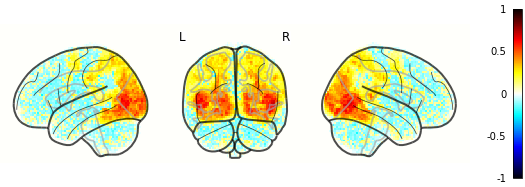

In the second track, brain responses provided are from a set of specific regions of interest (ROIs) known to play a key role in visual perception. These ROIs start in early and mid-level visual cortex (V1, V2, V3, and V4) and extend into higher-level cortex that responds preferentially to all objects or particular categories (Body- EBA; Face - FFA, STS; Object - LOC; Scene - PPA). In the figure below we show the masks of the above mentioned ROIs for an example subject.


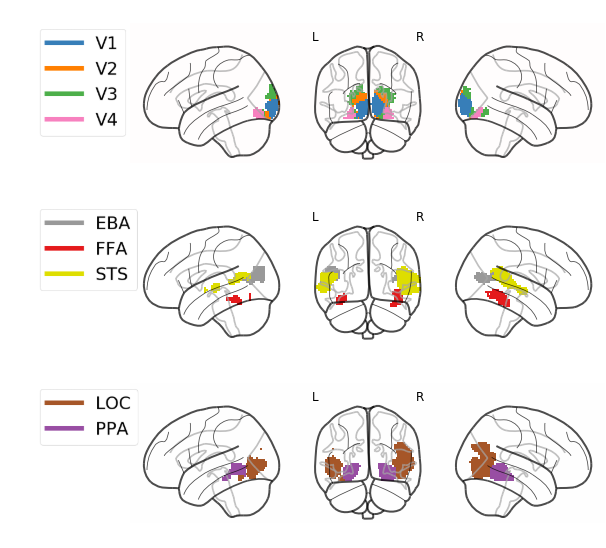

#Loading fMRI data
The dataset contains 1,000 3-second videos + fMRI human brain data of 10 subjects in response to viewing videos from this set. 

The ROI data is provided for 9 ROIs of the visual brain (V1, V2, V3, V4, LOC, EBA, FFA, STS, PPA) in a Pickle file (e.g. V1.pkl) that contains a num_videos x num_repetitions x num_voxels matrix. For each ROI, we selected voxels that showed significant split-half reliability.

The whole brain data is provided for selected voxels across the whole brain showing reliable responses to videos in a Pickle file (e.g. WB.pkl) that contains a num_videos x num_repetitions x num_voxels matrix.

In this section, we demonstrate how to load fMRI data for a given ROI. 

In [3]:
# @title Utility functions for data loading
def save_dict(di_, filename_):
  with open(filename_, 'wb') as f:
    pickle.dump(di_, f)


def load_dict(filename_):
  with open(filename_, 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    ret_di = u.load()
    # print(p)
    # ret_di = pickle.load(f)
  return ret_di


def visualize_activity(vid_id, sub):
  # Setting up the paths for whole brain data
  fmri_dir = './participants_data_v2021'
  track = "full_track"

  # get the right track directory depending on whole brain/ROI choice
  track_dir = os.path.join(fmri_dir, track)

  # get the selected subject's directory
  sub_fmri_dir = os.path.join(track_dir, sub)

  # result directory to store nifti file
  results_dir = '/content/'
  if not os.path.exists(results_dir):
      os.makedirs(results_dir)

  # mapping the data to voxels and storing in a nifti file
  fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir, "WB")
  visual_mask_3D = np.zeros((78, 93, 71))
  visual_mask_3D[voxel_mask==1]= fmri_train_all[vid_id, :]
  brain_mask = './example.nii'
  nii_save_path = os.path.join(results_dir, 'vid_activity.nii')
  saveasnii(brain_mask, nii_save_path, visual_mask_3D)

  # visualizing saved nifti file
  plotting.plot_glass_brain(nii_save_path,
                          title='fMRI response',plot_abs=False,
                          display_mode='lyr',colorbar=True)


def get_fmri(fmri_dir, ROI):
  """This function loads fMRI data into a numpy array for to a given ROI.
  Parameters
  ----------
  fmri_dir : str
    path to fMRI data.
  ROI : str
    name of ROI.
  Returns
  -------
  np.array
    matrix of dimensions #train_vids x #repetitions x #voxels
    containing fMRI responses to train videos of a given ROI
  """
  # Loading ROI data
  ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
  ROI_data = load_dict(ROI_file)
  # averaging ROI data across repetitions
  ROI_data_train = np.mean(ROI_data["train"], axis=1)
  if ROI == "WB":
    voxel_mask = ROI_data['voxel_mask'] # 3D binary mask with the shape (78, 93, 71), identifies voxels of interest
    return ROI_data_train, voxel_mask

  return ROI_data_train


def saveasnii(brain_mask, nii_save_path, nii_data):
  img = nib.load(brain_mask)
  nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
  nib.save(nii_img, nii_save_path)

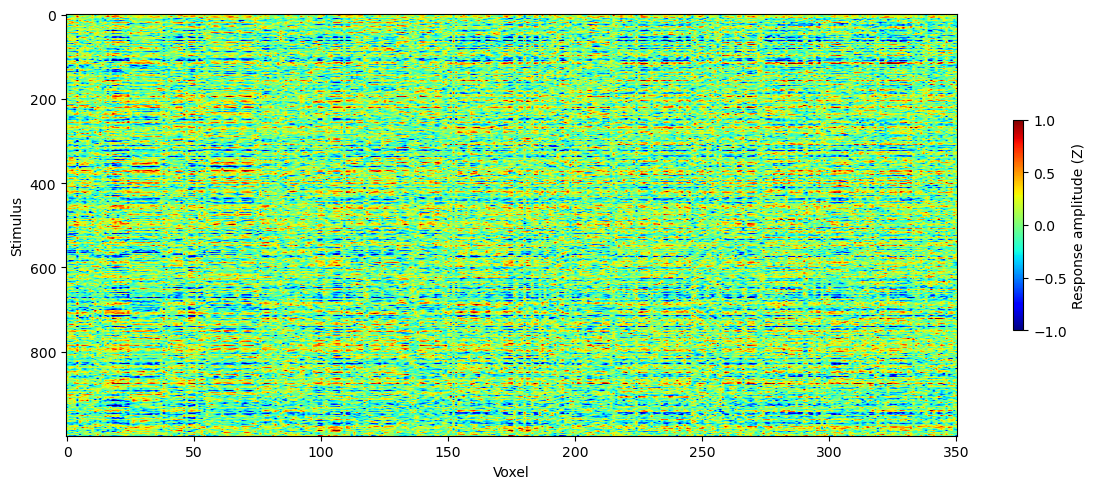

In [4]:
# @title Loading fMRI data and inspecting dimensions
# Select Subject
sub = 'sub01'  #@param ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]

# Select ROI
ROI = 'EBA'  #@param ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]

######## fMRI data loader wrapper code ###################################
fmri_dir = './participants_data_v2021'
if ROI == "WB":  # Loading whole brain data
  track = "full_track"  # stored in full_track directory
else:  # Loading ROI data
  track = "mini_track" # stored in mini_track directory

# get the right track directory depending on whole brain/ROI choice
track_dir = os.path.join(fmri_dir, track)

# get the selected subject's directory
sub_fmri_dir = os.path.join(track_dir, sub)

# Load the fMRI data for the selected subject and ROI
if track == "full_track":
  fmri_train_all,_ = get_fmri(sub_fmri_dir,ROI)
else:
  fmri_train_all = get_fmri(sub_fmri_dir,ROI)

######## fMRI data loader wrapper code ###################################

# Visualize the fMRI responses in a heatmap
f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(fmri_train_all, aspect="auto", cmap='jet', vmin=-1, vmax=1)
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()

In [25]:
print(fmri_train_all.shape)
print(_.shape)
print(_.shape[0]*_.shape[1]*_.shape[2])

print(ROI_data_train)

(1000, 18222)
(78, 93, 71)
515034


In [ ]:
fmri_train_all,voxel_mask = get_fmri("./participants_data_v2021/full_track/sub01", "WB")

In [5]:
ROI_data = load_dict("./participants_data_v2021/full_track/sub04/WB.pkl")


In [6]:
ROI_data.keys()

dict_keys(['train', 'voxel_mask'])

In [7]:
print(ROI_data["train"].shape)
print(ROI_data["voxel_mask"].shape)
print(np.unique(ROI_data["voxel_mask"]))

(1000, 3, 19445)
(78, 93, 71)
[0. 1.]


In [33]:
print(ROI_data)

{'train': array([[[ 1.79809276e+00,  1.00652658e+00,  5.01486096e-01, ...,
         -5.21248398e-01, -1.09070092e+00, -4.15908609e-01],
        [ 1.06806278e+00,  1.95700854e-01,  9.47942379e-01, ...,
          1.38459316e-01,  1.04340058e+00,  5.30634671e-01],
        [ 2.62379243e-01,  5.94457052e-01,  4.45302290e-01, ...,
         -1.29313610e-01,  2.28680616e-01,  4.16733973e-01]],

       [[ 9.05718343e-02, -2.25393076e-01,  1.78690087e-02, ...,
         -3.48262020e-01, -1.55620376e-01, -5.84700795e-01],
        [ 3.03878832e-02,  9.31164708e-01,  1.12381873e+00, ...,
          7.07031959e-01, -2.58209128e-01,  1.06306505e-01],
        [-5.54318083e-01, -8.31143021e-01, -1.14896191e+00, ...,
          3.70863300e-01,  1.04901224e+00, -6.04371525e-01]],

       [[ 1.44957766e-03,  3.34016993e-01,  4.63729979e-01, ...,
         -1.20187541e-02,  3.86865288e-01, -6.31111323e-01],
        [ 6.44835648e-01,  6.95010468e-02, -2.09521419e-01, ...,
          7.86513596e-01, -2.58828151e-

In [38]:
fmri_train_EBA = get_fmri("./participants_data_v2021/mini_track/sub01", "EBA")

In [41]:
print(fmri_train_EBA.shape)

(1000, 351)


In [42]:
ROI_data_EBA = load_dict("./participants_data_v2021/mini_track/sub01/EBA.pkl")

In [44]:
ROI_data_EBA.keys()

dict_keys(['train'])

In [45]:
print(ROI_data_EBA["train"].shape)

(1000, 3, 351)


The above matrix shows each individual voxel's (columns) response to 1000 videos (rows). To find out more details about how the fMRI responses were preprocessed please click [here](http://algonauts.csail.mit.edu/brainmappingandanalysis.html). 

Visualize a given video (with id from 0-999)) and its corresponding brain activity

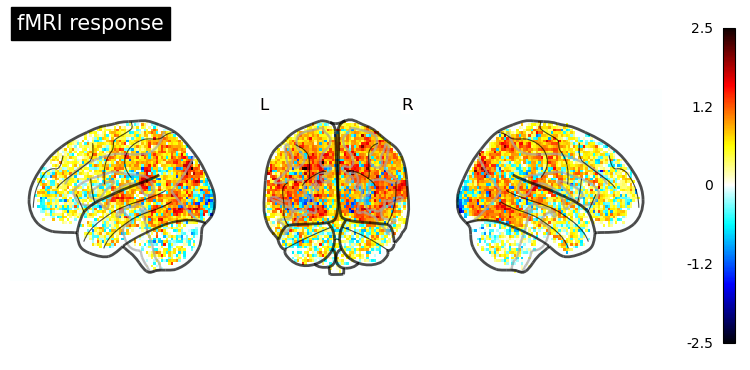

In [14]:
# @title Visualize corresponding brain response
visualize_activity(211, "sub02")

In [8]:
# @title Visualize video (adapted to PyCharm)
video_dir = './AlgonautsVideos268_All_30fpsmax'
video_files = sorted(glob.glob(video_dir + '/*.mp4'))
vid_id = 1  # @param {type: "integer"}

if video_files:
    # Create a video capture object
    cap = cv2.VideoCapture(video_files[vid_id])

    # Check if the video capture object was successfully created
    if not cap.isOpened():
        print("Error: Could not open video.")
    else:
        # Read and display video frames in a loop
        while True:
            ret, frame = cap.read()
            if ret:
                # Display the frame
                cv2.imshow('Video', frame)

                # Press 'q' to exit the video window before it ends
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                # Break the loop if there are no more frames
                break

    # Release the video capture object and close the display window
    cap.release()
    cv2.destroyAllWindows()
else:
    print("No video files found in the specified directory.")


KeyboardInterrupt: 

In [ ]:
# @title Visualize video (only works in Jupyter Notebook)
from IPython.display import HTML
from base64 import b64encode

vid_id = 0  # @param {type: "integer"}
video_dir = './AlgonautsVideos268_All_30fpsmax'

########### Video display code #################################################
video_list = glob.glob(video_dir + '/*.mp4')
video_list.sort()

mp4 = open(video_list[vid_id], 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
  <source src="%s" type="video/mp4">
</video>
""" % data_url)
########### Video display code #################################################

The values in the fMRI response above correspond to beta values from 5s to 9s after stimulus onset calculated using an Finite Impulse Response (FIR) model. The beta values were averaged across time and z-scored across videos. 

# Reference

Cichy et al., The Algonauts Project 2021 Challenge: How the Human Brain Makes Sense of a World in Motion. arXiv 2021. arXiv: [2104.13714v1](https://arxiv.org/abs/2104.13714v1)


